In [1]:
#! pip install h5py nibabel pandas glob2 regex
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os
import sys

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

import torch
import torch.nn as nn

In [2]:
# path
p = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005/TESTING_beforeLipid.mat'
p_cc = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005/CoilCombined.h5'
p_wat = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_05_A_1_2024-09-02_L2_0p0005/WaterReference.mat'
#p_train = '/workspace/walinet/PaulTrainData/3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005/TrainData/TrainData_v3.h5'

# Water Removal
b_RemWat = False
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 3000 # 3khz
dwell_time = 1/bandwidth

In [3]:
fh = h5py.File(p,'r')
#csi_crrrt = np.array(fh['csi'][:])
#csi_crrrt = csi_crrrt['real']+1j*csi_crrrt['imag']
#csi_crrrt = np.transpose(csi_crrrt, axes=(4,3,2,1,0)) # (32, 64, 64, 39, 960) (coils, xdim, ydim, slices, time)

mask = np.array(fh['mask'])
mask = np.transpose(mask, axes=(2,1,0))


#fh_wat = scipy.io.loadmat(p_wat)
#weights = fh_wat['weights']  # (32, 64, 64, 39) (coils, xdim, ydim, slices)

fh_cc = h5py.File(p_cc,'r')
csi_rrrt = np.array(fh_cc['csi_cc_rrrt'])

In [4]:
############################
##### Coil Combination #####
############################

#csi_rrrt = np.sum(csi_crrrt * weights[:,:,:,:,None], axis=0)


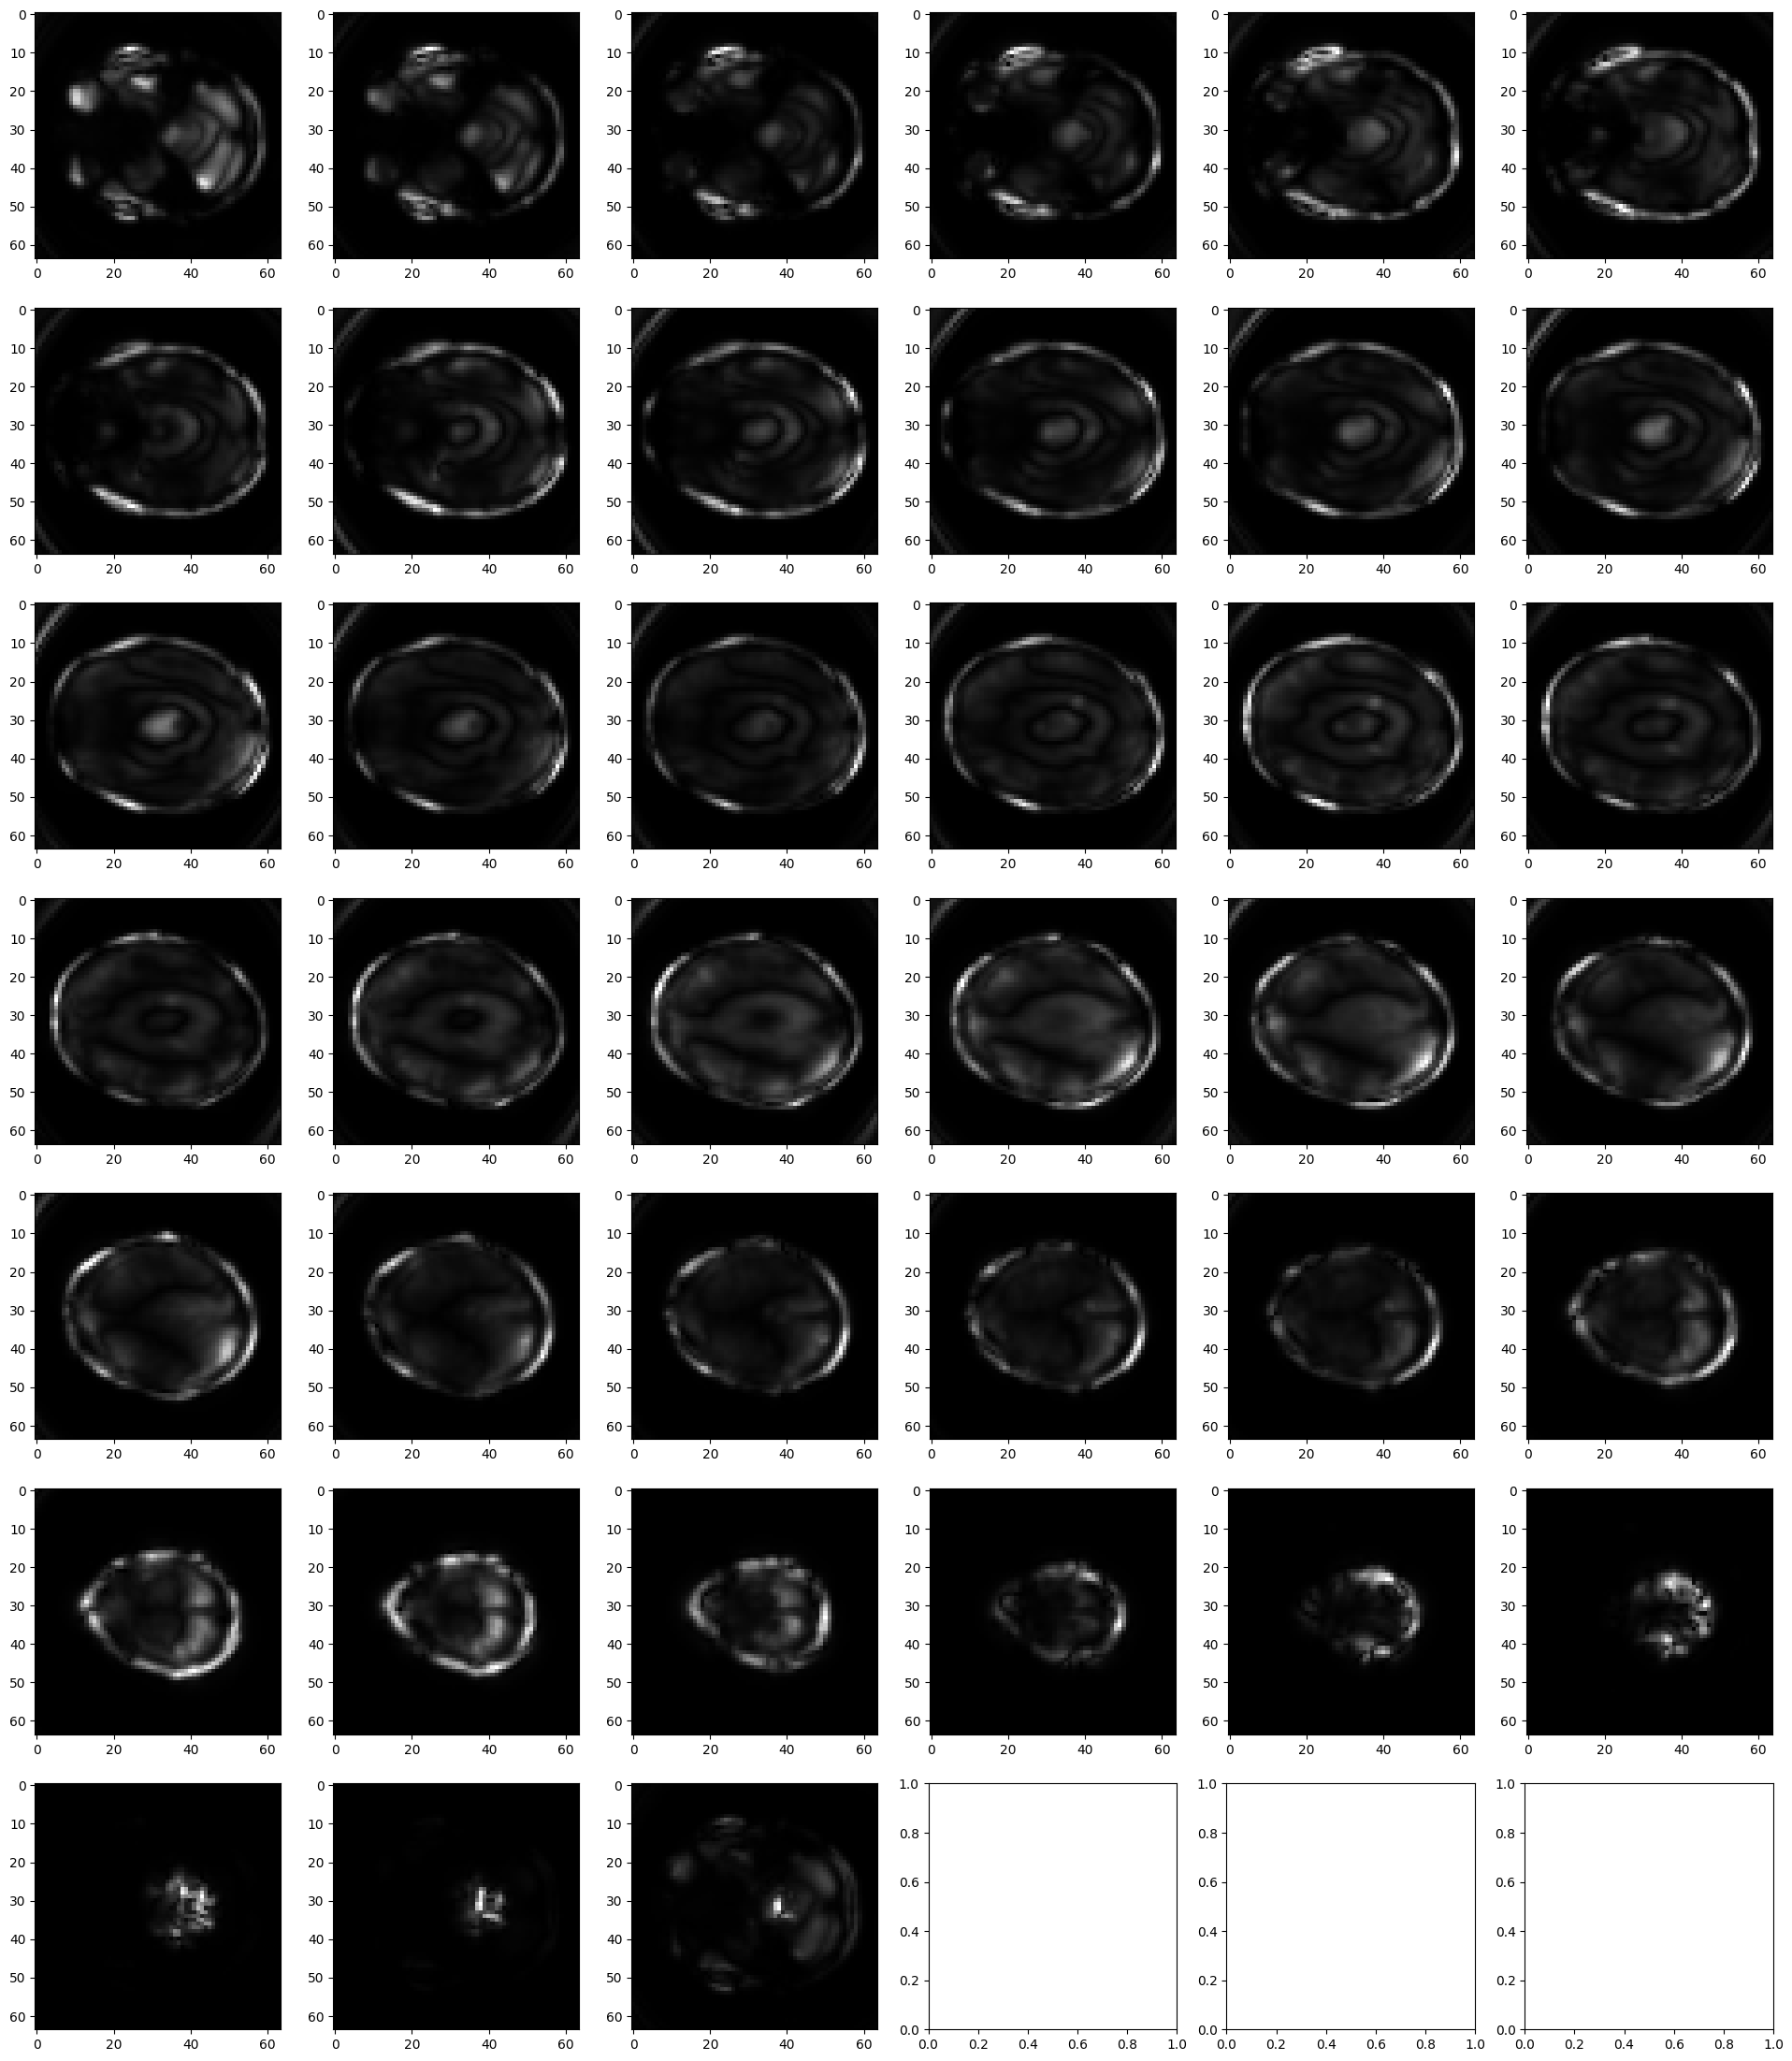

In [ ]:
rows=7
cols=6
winsz=4

sumimg = np.sum(np.abs(csi_rrrt),axis=-1)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*winsz,rows*winsz))
for i in range(rows):
    for ii in range(cols):
        sl = i*cols + ii
        if sl < 39:
            ax[i,ii].imshow(sumimg[:,:,sl],cmap='gray')
        
plt.show()


In [6]:
###########################
##### Mask Generation #####
###########################
size = csi_rrrt.shape

### Brainmask ###
brainmask = np.copy(mask)
bottom = int(np.floor(size[2]/4))


pad=3
ite=2
tmp = brainmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
brainmask += tmp[pad:-pad,pad:-pad,pad:-pad]
brainmask[brainmask>=1]=1

brainmask[:,:,:bottom]=0


### Headmask ###
nuisance_rrr = np.sum(np.abs(csi_rrrt), axis=-1)

x, y = np.indices((size[0], size[1]))
radius=int(np.floor(size[0]/2))
circ = (x-radius)**2+(y-radius)**2
thresh = radius**2
circ[circ<=thresh]=1
circ[circ>thresh]=0

headmask = circ[:,:,None]*nuisance_rrr

thresh2 = 0.01 * np.amax(headmask) #9*10**11
headmask[headmask<thresh2] = 0
headmask[headmask>=thresh2] = 1

pad=10
ite=8
for sl in range(size[2]):
    tmp = headmask[:,:,sl]
    tmp = np.pad(tmp, [(pad, pad), (pad, pad)])
    tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
    tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
    headmask[:,:,sl] += tmp[pad:-pad,pad:-pad]
headmask[headmask>=1]=1

pad=10
ite=8
tmp = headmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
headmask += tmp[pad:-pad,pad:-pad,pad:-pad]
headmask[headmask>=1]=1

headmask[:,:,:bottom]=0


skmask = headmask - brainmask

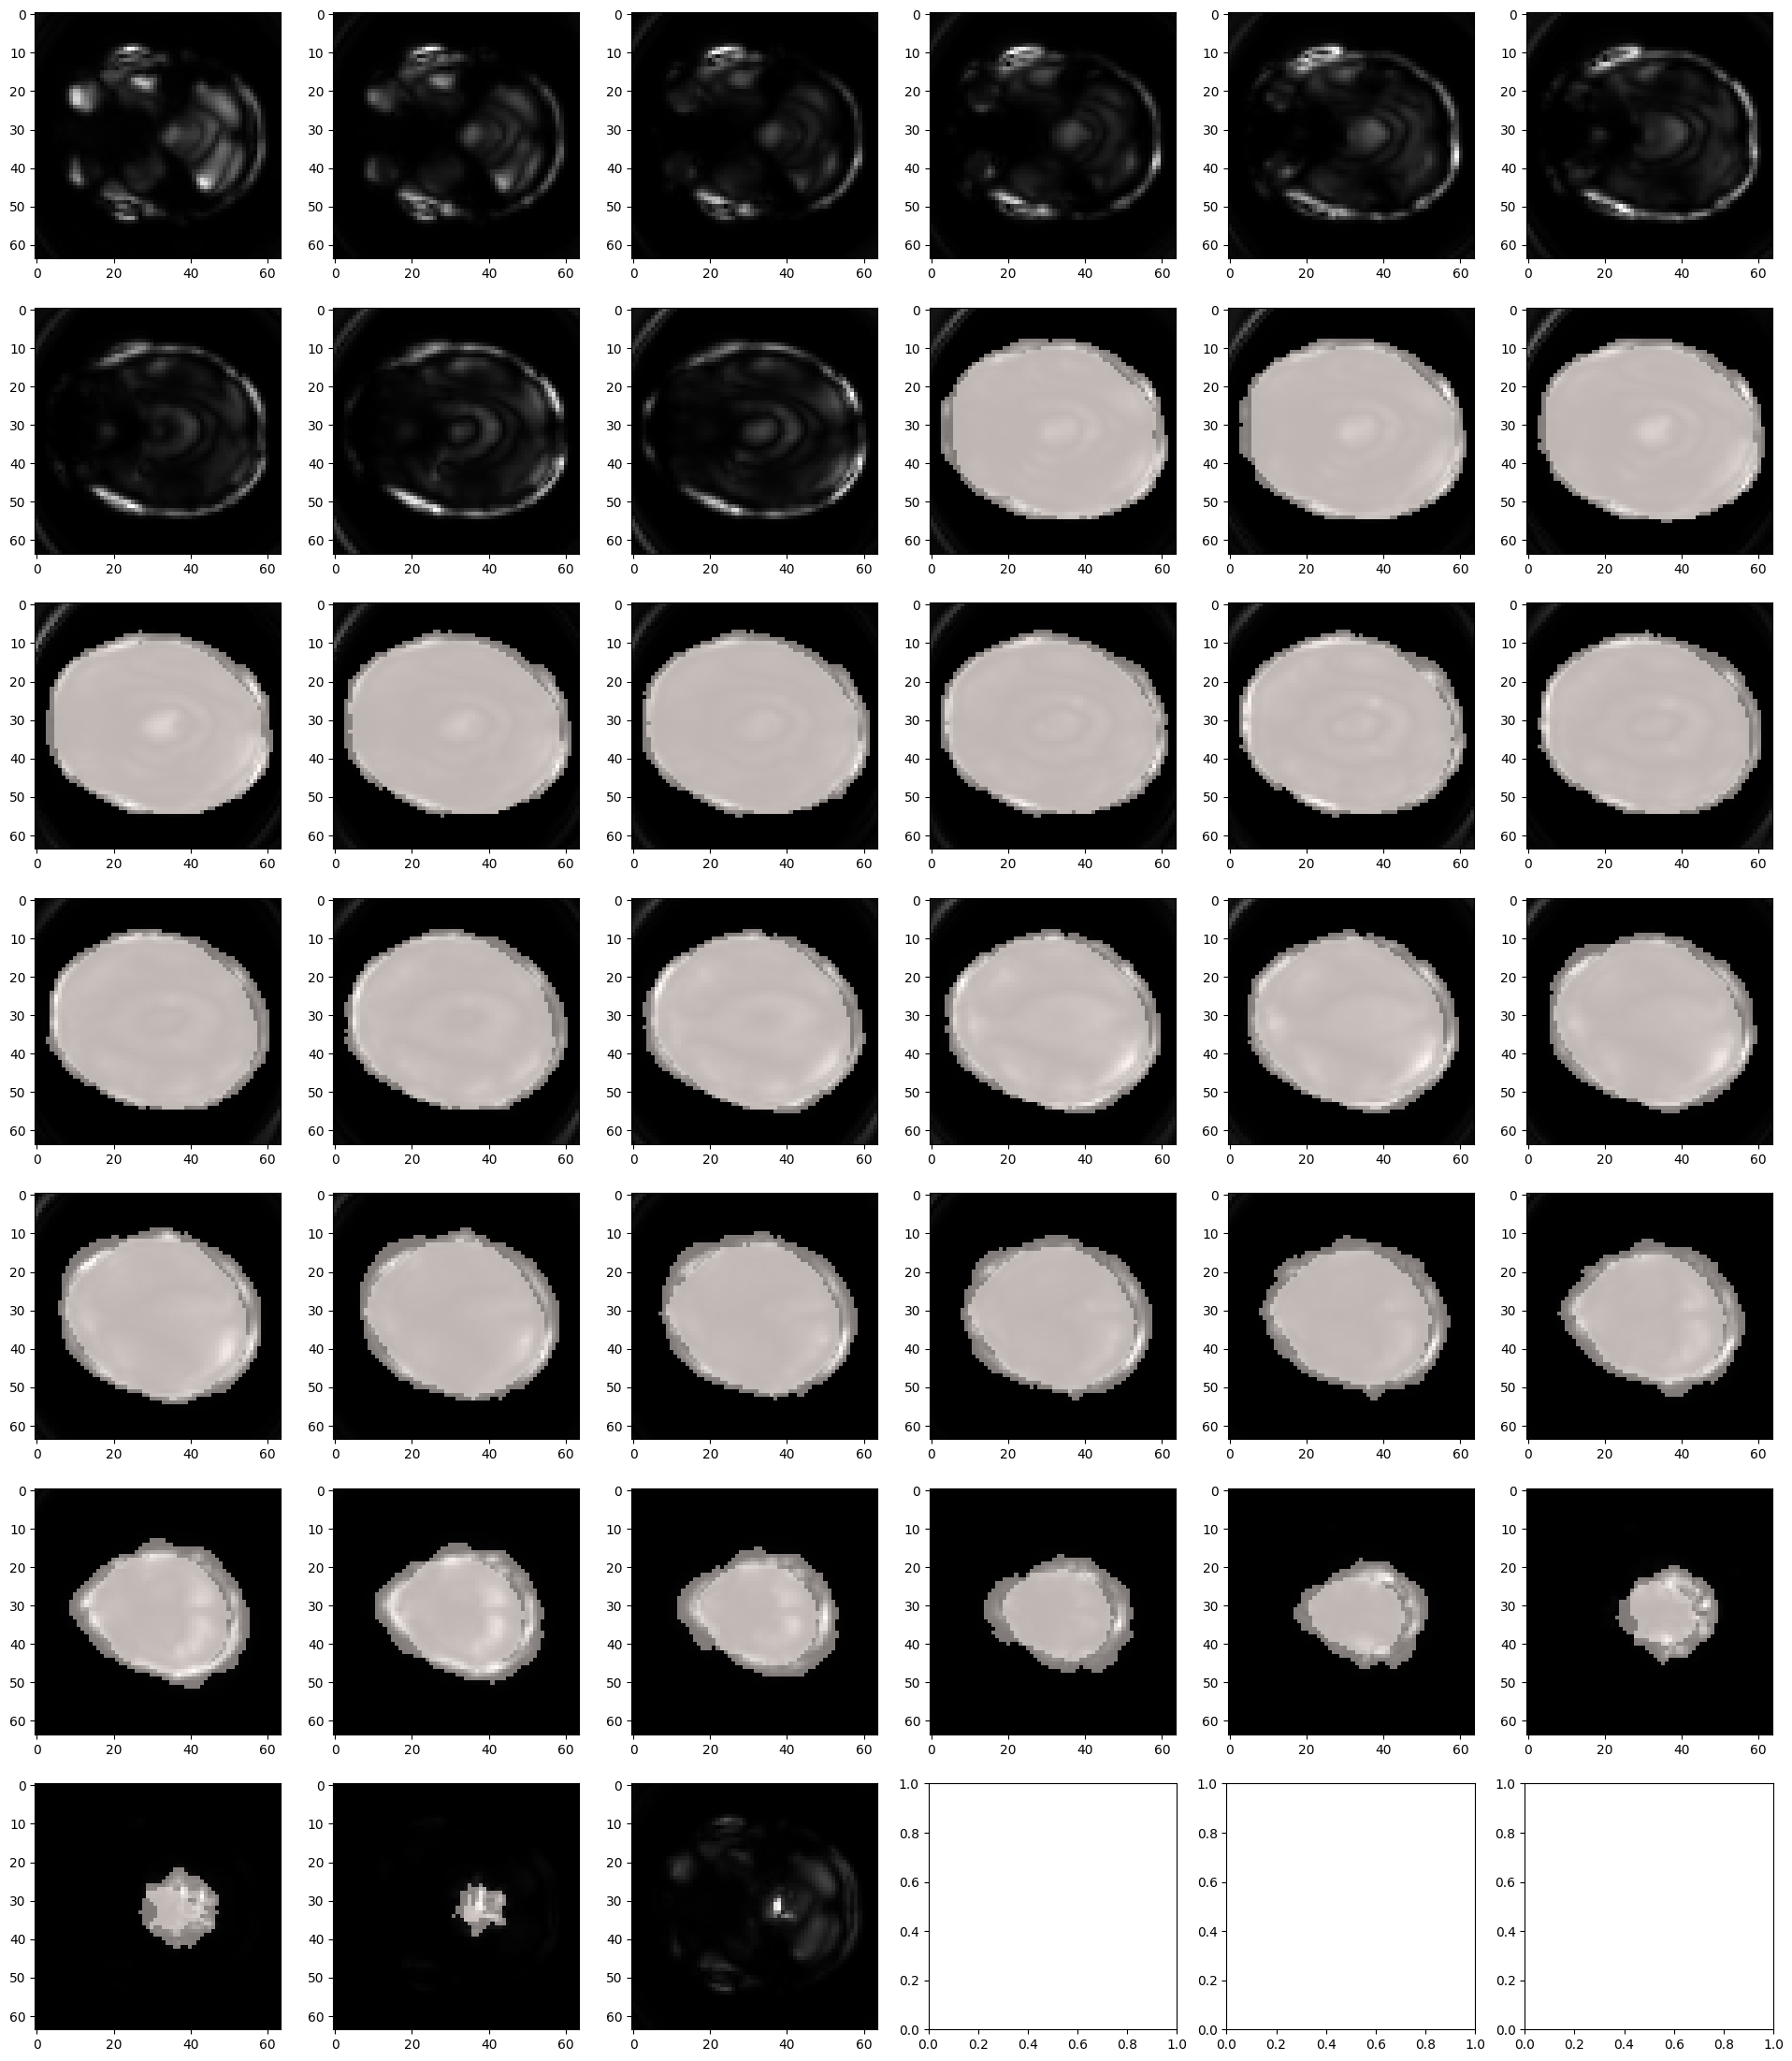

In [7]:
rows=7
cols=6
winsz=4

#tmp = np.sum(np.abs(csi_rrrt),axis=-1)
headmask_none = np.copy(headmask)
headmask_none[headmask_none==0]=None
brainmask_none = np.copy(brainmask)
brainmask_none[brainmask_none==0]=None
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*winsz,rows*winsz))
for i in range(rows):
    for ii in range(cols):
        sl = i*cols + ii
        if sl < 39:
            ax[i,ii].imshow(sumimg[:,:,sl],cmap='gray')
            ax[i,ii].imshow(brainmask_none[:,:,sl],cmap='Reds',alpha=0.5)
            ax[i,ii].imshow(headmask_none[:,:,sl],cmap='Reds',alpha=0.5)

plt.show()

In [8]:
#########################
##### Water Removal #####
#########################

def HSVD(y, fs, k):
    N = len(y)
    L = int(np.floor(0.5*N))

    # Hankel Matric and SVD
    H = scipy.linalg.hankel(y[:L], y[L:N])
    u, s, vh = np.linalg.svd(H)

    # Compute Z prime
    Uk = u[:,:k]
    Ukt = Uk[1:,:]
    Ukb = Uk[:-1,:]
    Zp = np.matmul(np.linalg.pinv(Ukb),Ukt)

    # Compute poles
    w, v = np.linalg.eig(Zp)
    Z = np.matmul(np.matmul(np.linalg.inv(v), Zp), v)
    q = np.log(np.diag(Z))
    dt = 1/fs
    dampings = np.real(q)/dt
    dampings[dampings>10] = 10
    frequencies = np.imag(q)/(2*np.pi)/dt

    # Construct Basis
    t = np.arange(start=0,stop=len(y)*dt,step=dt)
    basis = np.exp(np.matmul(t[:,None], (dampings+2*np.pi*1j*frequencies)[None,:]))

    # Compute the amplitude estimates
    amps = np.matmul(np.linalg.pinv(basis),y)
    return frequencies, dampings, basis, amps

if b_RemWat:
    print("####### Water Suppression #######")
    sta_time = time.time()

    image_grid = np.array(csi_rrrt)
    s = image_grid.shape
    image_rrrt = np.zeros(image_grid.shape, dtype=np.complex64)
    water_rrrt = np.zeros(image_grid.shape, dtype=np.complex64)


    def WaterSuppressionWrapper(image_rrrt, mask, fs, k, minFreq, maxFreq):
        global WaterSuppression
        def WaterSuppression(tup):
            (x,y,z)=tup
            fid = image_rrrt[x,y,z,:] 
            if mask[x,y,z]:
                #sta_time = time.time()
                frequencies, dampings, basis, amps = HSVD(y = fid,
                                                        fs = fs,
                                                        k = k)
                indx = np.where(np.logical_and(frequencies >= minFreq, maxFreq >= frequencies))[0]
                filtFid = fid - np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1)

                return (filtFid, x,y,z, np.sum(np.matmul(basis[:,indx], np.diag(amps[indx])), 1))
        return WaterSuppression

    WaterSuppression = WaterSuppressionWrapper(image_rrrt = image_grid, 
                                                mask = headmask,
                                                fs = 1/dwell_time, 
                                                k = WatSuppComp, 
                                                minFreq = minFreq, 
                                                maxFreq = maxFreq)

    all_sl = list(range(s[2]))
    i=0
    slices = []
    cur_tup = []
    while i < s[2]:
        if len(cur_tup) < 3-1 and i<s[2]-1:
            cur_tup.append(all_sl[i])
        else:
            cur_tup.append(all_sl[i])
            slices.append(tuple(cur_tup))
            cur_tup = []
        i+=1

    #print("all slices: ", slices)
    #slices=[(20,)]
    for sl in slices:
        print("Slice: ", sl)
        res = Parallel(n_jobs=parallel_jobs)(delayed(WaterSuppression)(tup=tup)
                            for tup in tqdm(product(range(s[0]), range(s[1]), sl), total=s[0]*s[1]*len(sl), position=0, leave=True))

        for tup in res:
            if tup is not None:
                filtFid, x, y, z, waterFid= tup
                image_rrrt[x,y,z] = filtFid
                water_rrrt[x,y,z] = waterFid

    sto_time = time.time()
    print('Water Removal: ', sto_time-sta_time)
else:
    image_rrrt = np.array(csi_rrrt)

In [9]:
!nvidia-smi

Wed Apr  2 20:33:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.5     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   87C    P0              56W / 300W |  13669MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
###################
##### Walinet #####
###################

def sine_filter(image_rrrt, nq1=1.5, sta=0):
    #print("####### Sine Filter #######")
    #print(image_rrrt.shape)

    # Define parameters
    phi1 = np.pi / 2
    phi2 = np.pi / 2
    #nq1 = 1.5

    # Size of the data
    SizeData = image_rrrt.shape
    T = np.arange(1, SizeData[-1]-sta + 1)

    # Generate the Sine-squared filter window
    qsine_win = np.power(np.sin((T - 1) / (SizeData[-1]-sta - 1) * phi1 + phi2), nq1)
    qsine_win = np.concatenate((np.ones((sta,)), qsine_win))
    qsine_win_111t = qsine_win.reshape(1, 1, 1, SizeData[-1])
    
    # Apply the filter
    image_rrrt = torch.tensor(qsine_win_111t) * image_rrrt
    
    return image_rrrt

def runNNLipRemoval2(image_rrrf, headmask, skMask, device, exp):
    sta_epoch = time.time()

    #################################
    ### Lipid Projection Operator ###
    #################################

    s = image_rrrf.shape
    beta=1E-29 * 3 
    multBeta = 1.5
    lipidFac = 0
    LipidTarget = 0.995 
    lower=None

    Data_rf = np.reshape(image_rrrf, (s[0]*s[1]*s[2],s[3]))
    lipid_mask = np.reshape(skMask, (s[0]*s[1]*s[2]))

    lipid_rf = Data_rf[lipid_mask>0,:]
    
    ## extend/shorten data here

    while np.abs(lipidFac-LipidTarget) > 0.005:
        LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
        ## Mean vlaue of diagonal should be 1 or above 0.9
        ## 
        #print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: ")
        lipidFac = np.mean(np.abs(np.diagonal(LipidRem_Operator_ff)))
        #print(lipidFac)

        if lipidFac < LipidTarget:
            beta = beta/multBeta
            if lower==False:
                multBeta=0.5*multBeta
            lower=True
        else:
            beta = beta*multBeta
            if lower==True:
                multBeta=0.5*multBeta
            lower=False

    LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
    LipidProj_Operator_ff = np.eye(s[-1])-LipidRem_Operator_ff
    
    

    ####################
    ### Prepare Data ###
    ####################

    lip = image_rrrf[headmask>0,:]
    lipProj = np.matmul(lip, LipidProj_Operator_ff)
    lip = torch.tensor(lip, dtype=torch.cfloat)
    lipProj = torch.tensor(lipProj, dtype=torch.cfloat)
    
    
    #####################
    ### Prepare Model ###
    #####################


    for f in os.listdir('/workspace/walinet/models/'+exp):
        if f.startswith("src"):
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/')
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/'+f)
            
            from config import params
            from src.initialize import initialize_model_folder, my_copy
            from src.training import training, validation
            from src.model import yModel
            break

      
    model = yModel(nLayers=params["nLayers"], 
                    nFilters=params["nFilters"], 
                    dropout=0,
                    in_channels=params["in_channels"], 
                    out_channels=params["out_channels"]
                    )
    

    params["path_to_model"] = "/workspace/walinet/models/"+exp+"/"
    model.load_state_dict(torch.load(params["path_to_model"] + 'model_last.pt', map_location=device))
    model.to(device)


    #####################
    ### Remove Lipids ###
    #####################

    Data_Lipid_rf = runModelOnLipData(lip=lip, 
                                        lipProj=lipProj, 
                                        model=model,
                                        device=device)

    #Data_LipidRemoved_rrrf = np.zeros(image_rrrf.shape, dtype=np.cfloat)
    #Data_LipidRemoved_rrrf[headmask>0,:] = Data_LipidRemoved_rf.numpy()

    Data_Lipid_rrrf = np.zeros(image_rrrf.shape, dtype=np.cfloat)
    Data_Lipid_rrrf[headmask>0,:] = Data_Lipid_rf.numpy()

    #return Data_LipidRemoved_rrrf, Data_Lipid_rrrf
    return Data_Lipid_rrrf



def runModelOnLipData(lip, lipProj, model, device):
    
    spectra_energy = torch.sqrt(torch.sum(torch.abs(lip-lipProj)**2, dim=1))[:,None]
    lip /= spectra_energy
    lip = torch.stack((torch.real(lip), torch.imag(lip)), axis=1)
    lipProj /= spectra_energy
    lipProj = torch.stack((torch.real(lipProj), torch.imag(lipProj)), axis=1)

    prediction = torch.zeros(lip.shape, dtype=torch.cfloat)
    datasz = lipProj.shape[0]
    batchsz = 200
    
    loss_func = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for i in range(int(datasz/batchsz)+1):
            log = 'Percent: {:.2f}%'
            percent = (i+1)/int(datasz/batchsz)*100
            print(log.format(percent), end='\r')
            lip_batch = lip[i*batchsz:(i+1)*batchsz,:,:]
            lipProj_batch = lipProj[i*batchsz:(i+1)*batchsz,:,:]
            
            lip_batch, lipProj_batch = lip_batch.to(device), lipProj_batch.to(device)
            pred = model(lip_batch, lipProj_batch)[:,:2,:].cpu()
            prediction[i*batchsz:(i+1)*batchsz,:] = pred
    
    
    prediction = prediction[:,0] + 1j*prediction[:,1]
    prediction = prediction*spectra_energy
    lip = lip[:,0] + 1j*lip[:,1]
    lip = lip * spectra_energy
    ### reverse effect here
    #Data_LipidRemoved_rf = lip - prediction
    
    #return Data_LipidRemoved_rf, prediction
    return prediction


print("####### Walinet #######")
sta_time = time.time()

# Walinet
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#exp='EXP_2p3'
exp='EXP_3p4'

#image_rrrt = np.array(csi_rrrt)

#imageShort_rrrt = image_rrrt[:,:,:,:860]
#s = imageShort_rrrt.shape

s = image_rrrt.shape

ModelVecSize = 960



if s[-1] < ModelVecSize:
    imageSine_rrrt = sine_filter(imageShort_rrrt, sta=0)
    imagePad_rrrt = np.pad(imageSine_rrrt, ((0,0),(0,0),(0,0),(0,ModelVecSize-s[-1])), 'constant')
    image_rrrf = np.fft.fftshift(np.fft.fft(imagePad_rrrt,axis=-1),axes=-1)
else:
    image_rrrf = np.fft.fftshift(np.fft.fft(image_rrrt,axis=-1),axes=-1)


Data_Lipid_rrrf = runNNLipRemoval2(image_rrrf, #csi_rrrt
                                    headmask=headmask, 
                                    skMask=skmask, 
                                    device=device,
                                    exp=exp)

if s[-1] < ModelVecSize:
    Data_Lipid_rrrt = np.fft.ifft( np.fft.ifftshift(Data_Lipid_rrrf,axes=-1),axis=-1)
    Data_Lipid_rrrt = Data_Lipid_rrrt[:,:,:,:s[-1]]
    Data_Lipid_rrrf = np.fft.fftshift(np.fft.fft(Data_Lipid_rrrt,axis=-1),axes=-1)
    Data_LipidRemovedShort_rrrf = np.fft.fftshift(np.fft.fft(imageShort_rrrt,axis=-1),axes=-1) - Data_Lipid_rrrf
    Data_LipidRemovedSine_rrrf = np.fft.fftshift(np.fft.fft(imageSine_rrrt,axis=-1),axes=-1) - Data_Lipid_rrrf
else:
    Data_LipidRemoved_rrrf = np.fft.fftshift(np.fft.fft(image_rrrt,axis=-1),axes=-1) - Data_Lipid_rrrf
Data_LipidRemoved_rrrf = Data_LipidRemoved_rrrf*headmask[:,:,:,None]

sto_time = time.time()
print('Walinet: ', sto_time-sta_time)

####### Walinet #######
cuda:0
Walinet:  84.23836135864258


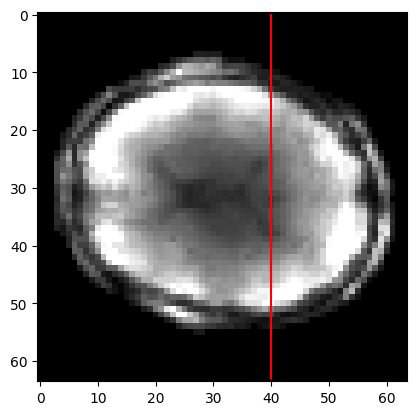

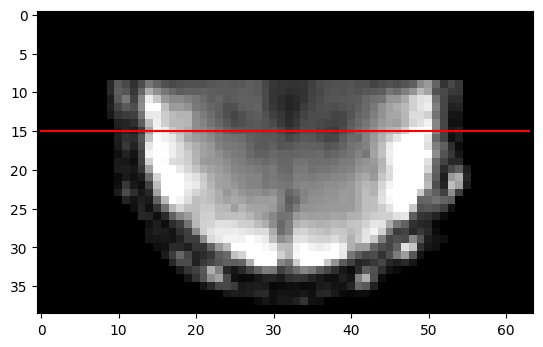

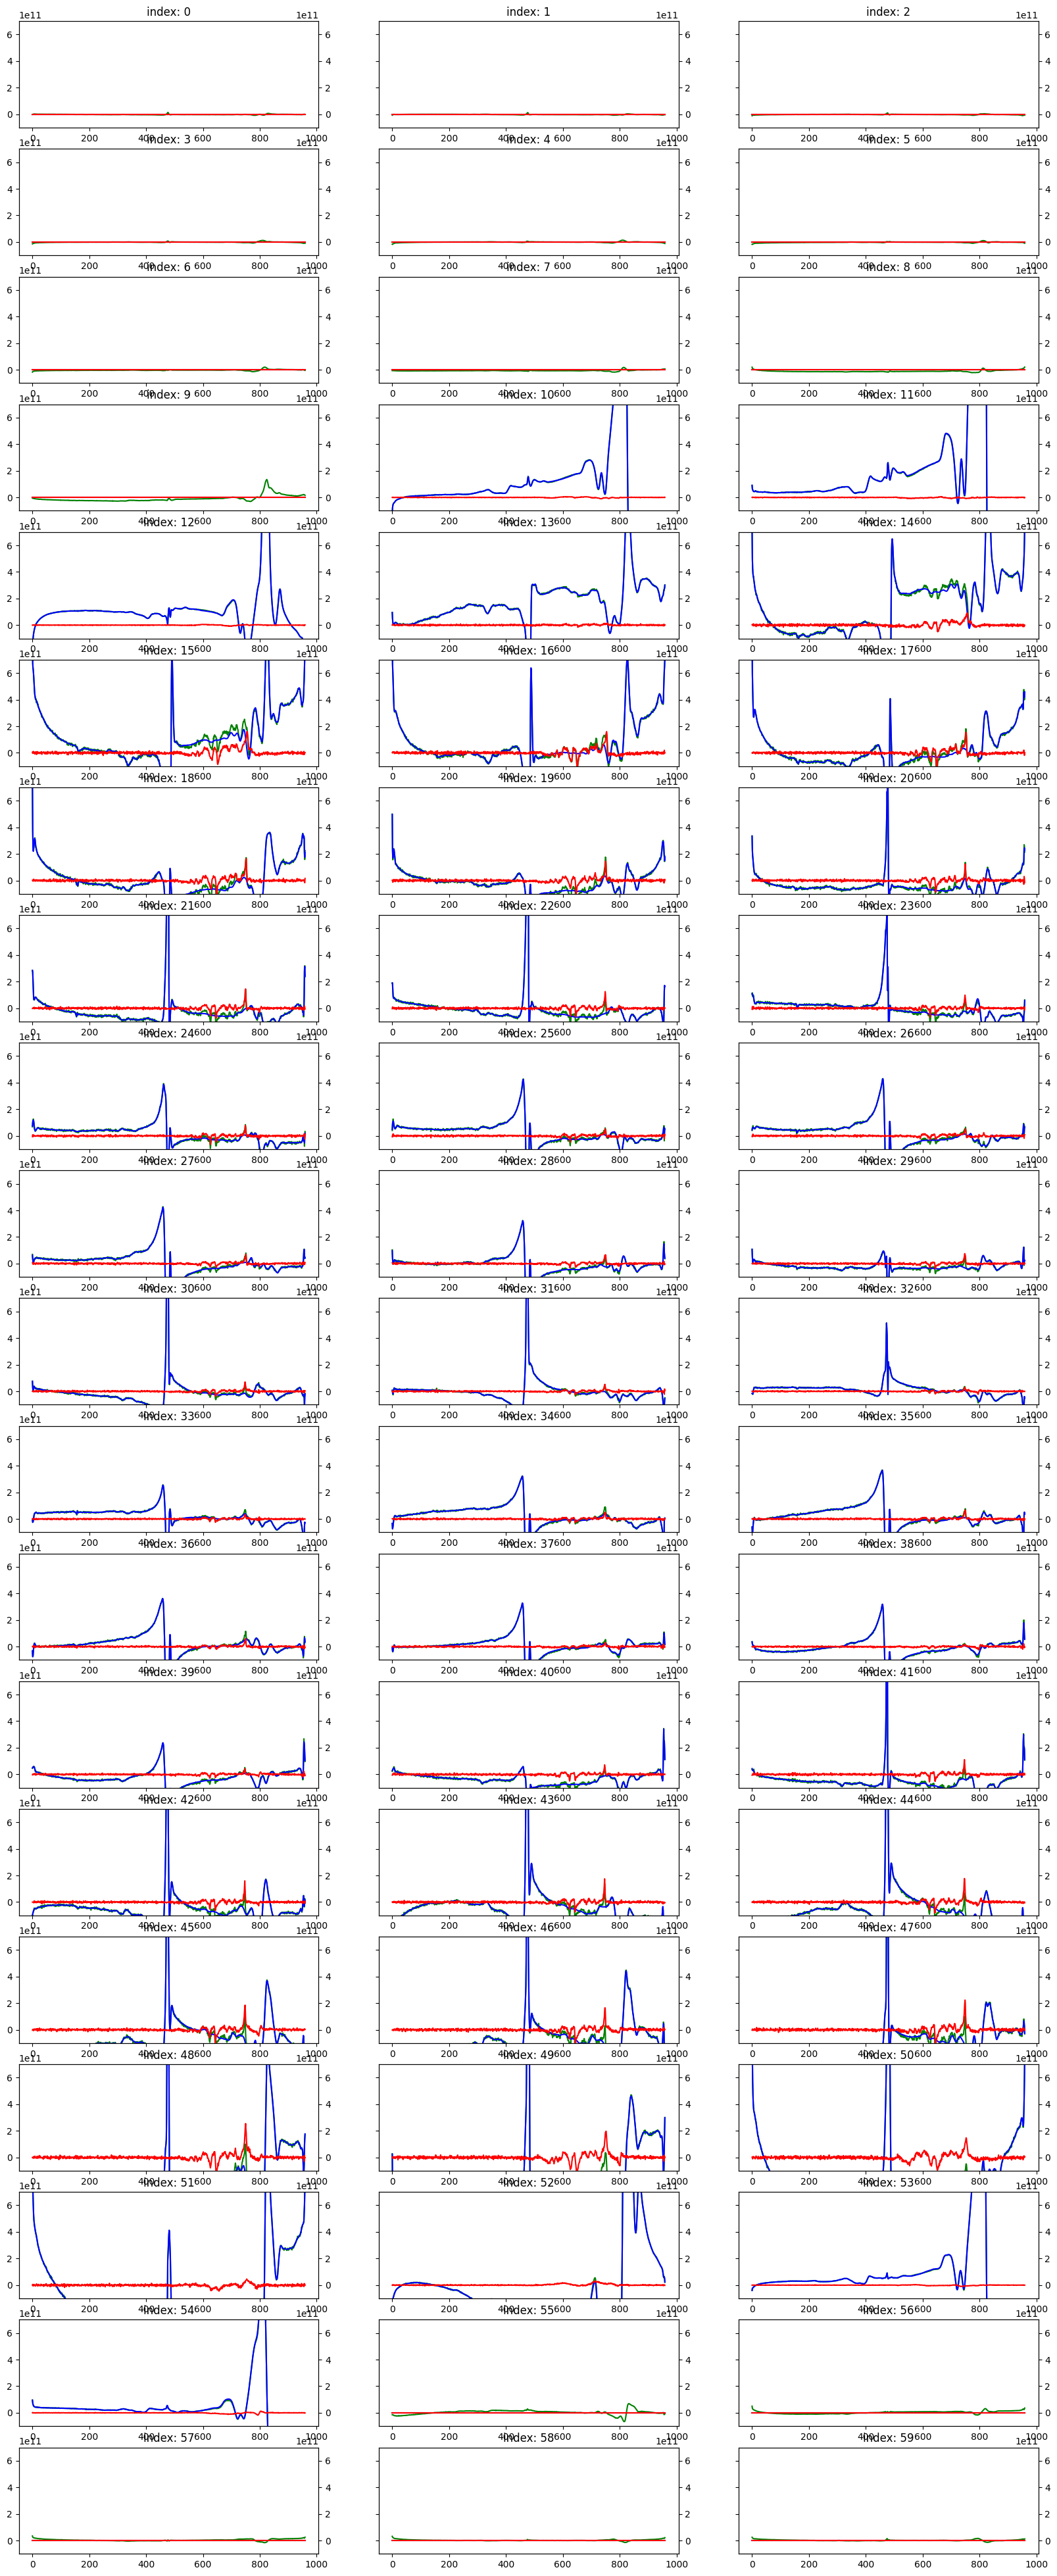

In [24]:
zdim=15
ydim=40#25

sum_img_grid = np.sum(np.abs(Data_LipidRemoved_rrrf), axis=-1)



plt.imshow(sum_img_grid[:,:,zdim], cmap="gray", vmax=18994869145125)
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
#plt.savefig("images/Subject"+sub+"_"+exp+"_brain")
plt.show()
plt.imshow(np.flip(np.rot90(sum_img_grid[:,ydim,:], k=3), axis=1), cmap="gray", vmax=18994869145125)
x = [0,63]
y = [zdim, zdim]
plt.plot(x,y,'red')
plt.show()



fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,50), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii
        
        
        fid2 = image_rrrt[sl,ydim,zdim,:]
        spec2 = np.fft.fftshift(np.fft.fft(fid2))
        ax[i,ii].plot(np.real(spec2), label='origShort', color='green')
        #fid2 = imageShort_rrrt[sl,ydim,zdim,:]
        #spec2 = np.fft.fftshift(np.fft.fft(fid2))
        #ax[i,ii].plot(np.abs(spec2), label='origShort', color='green')
        #fid2 = imageSine_rrrt[sl,ydim,zdim,:]
        #spec2 = np.fft.fftshift(np.fft.fft(fid2))
        #ax[i,ii].plot(np.abs(spec2), label='origSine', color='brown')
        
        spec4 = Data_Lipid_rrrf[sl,ydim,zdim,:]
        ax[i,ii].plot(np.real(spec4), label='pred', color='blue')
        ax[i,ii].set_ylim([-1*1e11,7*1e11])
        #ax[i,ii].legend()
        
        ax2 = ax[i,ii].twinx()
        spec1 = Data_LipidRemoved_rrrf[sl,ydim,zdim,:]
        ax2.plot(np.real(spec1), label='pred', color='red')
        #spec1 = Data_LipidRemovedSine_rrrf[sl,ydim,zdim,:]
        #ax2.plot(np.abs(spec1), label='pred', color='red')
        #spec1 = Data_LipidRemovedShort_rrrf[sl,ydim,zdim,:]
        #ax2.plot(np.abs(spec1), label='pred', color='orange')
        ax2.set_ylim([-1*1e11,7*1e11])
        #ax2.legend()
        ax[i,ii].title.set_text('index: ' + str(sl))
        
        
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()